In [1]:
# Taken from https://github.com/GunhoChoi/AnoGAN-Pytorch

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # set gpu number to use

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже)
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

In [3]:
epoch = 50
batch_size = 1000
learning_rate = 0.0002
num_gpus = 1
anomaly_digit = 0

In [4]:
# Download Data

mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = dset.MNIST("./", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

In [5]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [6]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [7]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()).cuda()
discriminator = nn.DataParallel(Discriminator()).cuda()

In [8]:
# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(2):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

In [9]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass



--------model not restored--------



/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


0th iteration gen_loss: 0.34072911739349365 dis_loss: 0.6221826076507568
0th iteration gen_loss: 0.6376552581787109 dis_loss: 0.1451905071735382


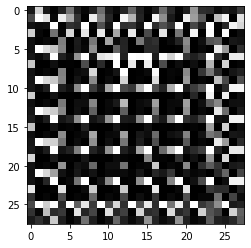

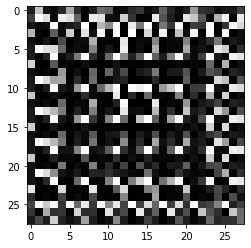

1th iteration gen_loss: 0.6391959190368652 dis_loss: 0.11652404069900513
1th iteration gen_loss: 0.3568710684776306 dis_loss: 0.5109760761260986


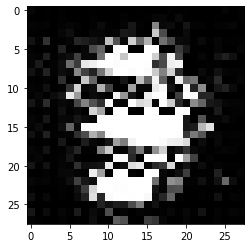

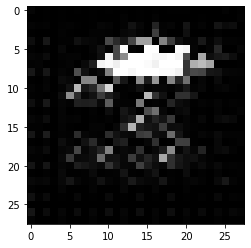

2th iteration gen_loss: 0.3785472810268402 dis_loss: 0.4163190722465515
2th iteration gen_loss: 0.3152269423007965 dis_loss: 0.5040330290794373


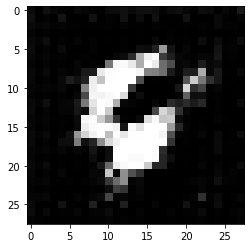

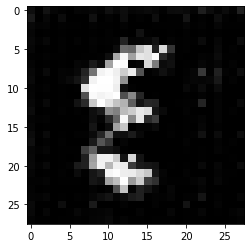

3th iteration gen_loss: 0.33286553621292114 dis_loss: 0.4901196360588074
3th iteration gen_loss: 0.2974664866924286 dis_loss: 0.4849628806114197


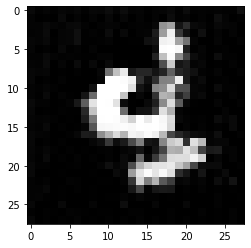

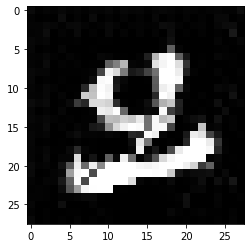

4th iteration gen_loss: 0.31536832451820374 dis_loss: 0.4781445860862732
4th iteration gen_loss: 0.28213566541671753 dis_loss: 0.5185717344284058


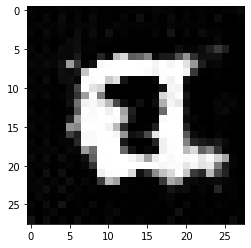

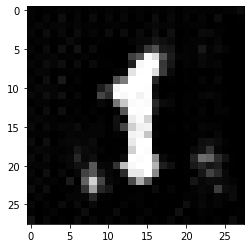

5th iteration gen_loss: 0.3349107801914215 dis_loss: 0.46586406230926514
5th iteration gen_loss: 0.288860023021698 dis_loss: 0.47040385007858276


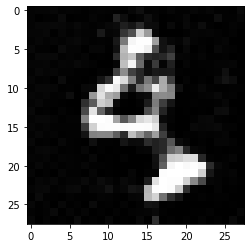

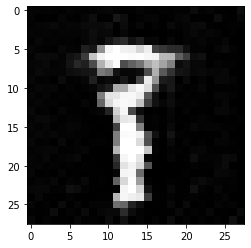

6th iteration gen_loss: 0.3060920238494873 dis_loss: 0.4714526832103729
6th iteration gen_loss: 0.30060383677482605 dis_loss: 0.46579256653785706


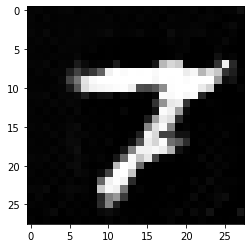

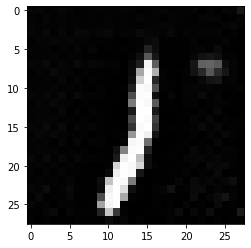

7th iteration gen_loss: 0.2974245548248291 dis_loss: 0.4547159671783447
7th iteration gen_loss: 0.29825684428215027 dis_loss: 0.46137580275535583


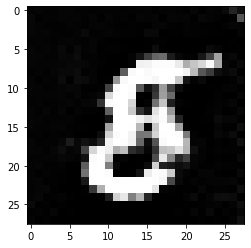

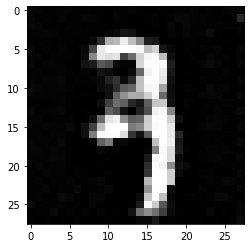

8th iteration gen_loss: 0.28544917702674866 dis_loss: 0.4549771845340729
8th iteration gen_loss: 0.27214884757995605 dis_loss: 0.4860149621963501


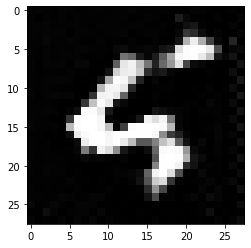

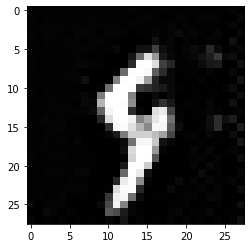

9th iteration gen_loss: 0.2772154211997986 dis_loss: 0.4820723533630371
9th iteration gen_loss: 0.2740284204483032 dis_loss: 0.47216522693634033


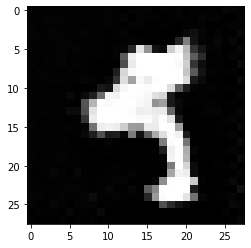

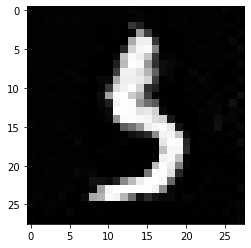

10th iteration gen_loss: 0.29949384927749634 dis_loss: 0.4767271876335144
10th iteration gen_loss: 0.2547056972980499 dis_loss: 0.4860304594039917


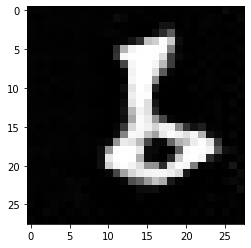

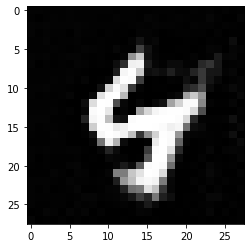

11th iteration gen_loss: 0.2631814181804657 dis_loss: 0.49781742691993713
11th iteration gen_loss: 0.278626412153244 dis_loss: 0.5004146695137024


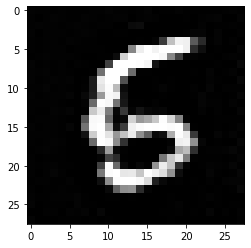

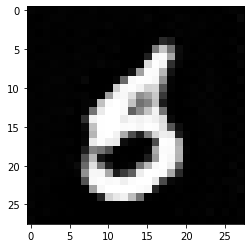

12th iteration gen_loss: 0.27034512162208557 dis_loss: 0.49264514446258545
12th iteration gen_loss: 0.2823522984981537 dis_loss: 0.4616316556930542


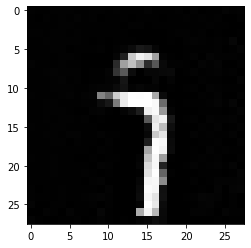

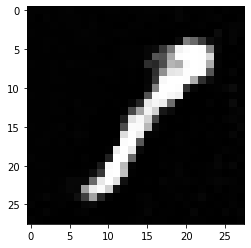

13th iteration gen_loss: 0.2720721960067749 dis_loss: 0.4919319152832031
13th iteration gen_loss: 0.29515042901039124 dis_loss: 0.4795458912849426


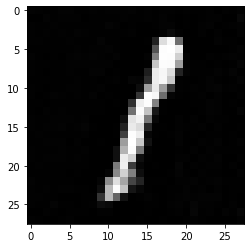

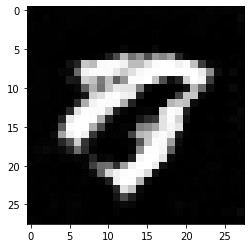

14th iteration gen_loss: 0.3023947775363922 dis_loss: 0.487307608127594
14th iteration gen_loss: 0.2582995295524597 dis_loss: 0.4928182065486908


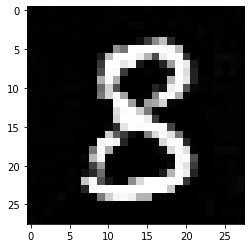

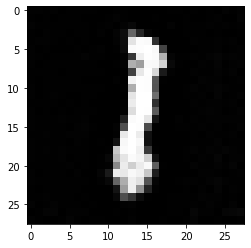

15th iteration gen_loss: 0.28962498903274536 dis_loss: 0.48123133182525635
15th iteration gen_loss: 0.2608599066734314 dis_loss: 0.48622292280197144


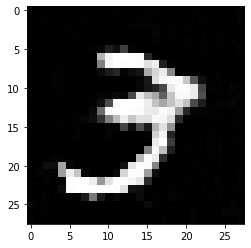

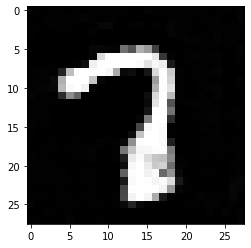

16th iteration gen_loss: 0.2712852656841278 dis_loss: 0.4904530644416809
16th iteration gen_loss: 0.2977711856365204 dis_loss: 0.4813203811645508


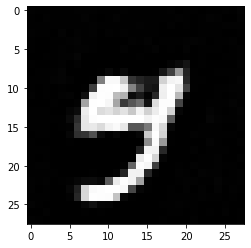

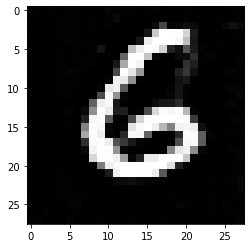

17th iteration gen_loss: 0.2909890115261078 dis_loss: 0.49431055784225464
17th iteration gen_loss: 0.29067355394363403 dis_loss: 0.4713091254234314


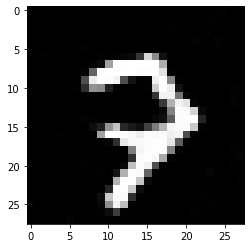

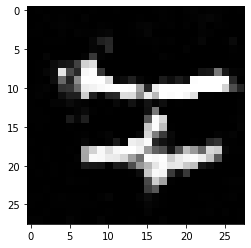

18th iteration gen_loss: 0.2712703049182892 dis_loss: 0.47867679595947266
18th iteration gen_loss: 0.28651151061058044 dis_loss: 0.5127487182617188


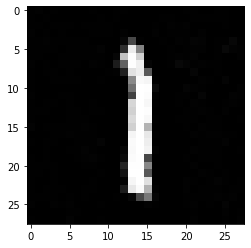

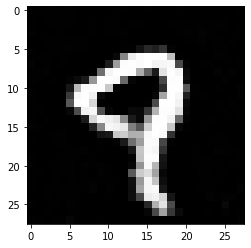

19th iteration gen_loss: 0.3459606170654297 dis_loss: 0.4521484076976776
19th iteration gen_loss: 0.2612927556037903 dis_loss: 0.4566006362438202


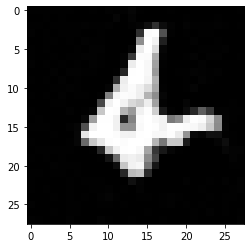

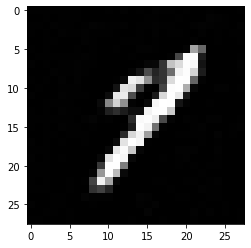

20th iteration gen_loss: 0.24800918996334076 dis_loss: 0.43707841634750366
20th iteration gen_loss: 0.3613226115703583 dis_loss: 0.5015812516212463


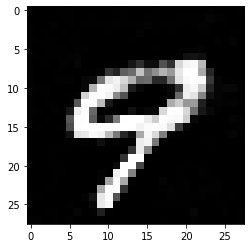

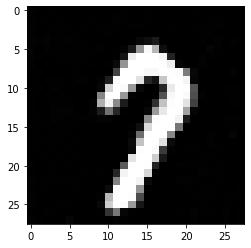

21th iteration gen_loss: 0.27981606125831604 dis_loss: 0.46054786443710327
21th iteration gen_loss: 0.2888105809688568 dis_loss: 0.48072221875190735


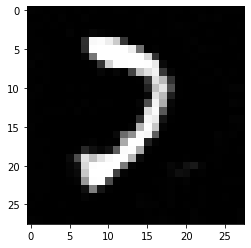

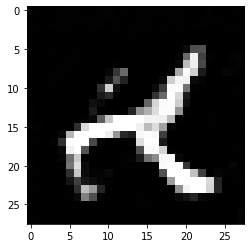

22th iteration gen_loss: 0.2880440950393677 dis_loss: 0.4578857719898224
22th iteration gen_loss: 0.2953135371208191 dis_loss: 0.49305790662765503


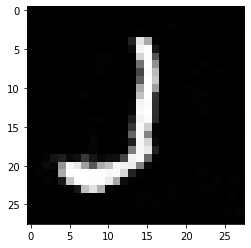

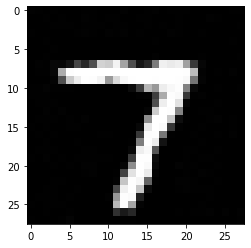

23th iteration gen_loss: 0.32280588150024414 dis_loss: 0.4825317859649658
23th iteration gen_loss: 0.309571772813797 dis_loss: 0.4706798195838928


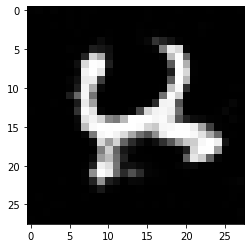

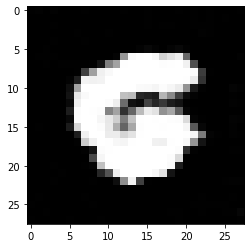

24th iteration gen_loss: 0.3984890282154083 dis_loss: 0.4665687680244446
24th iteration gen_loss: 0.29176104068756104 dis_loss: 0.5025148987770081


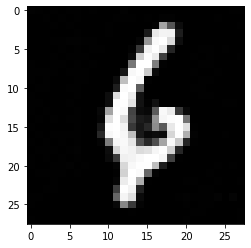

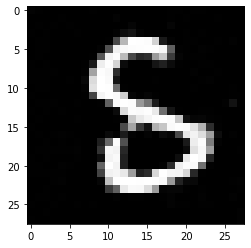

25th iteration gen_loss: 0.2744465172290802 dis_loss: 0.46649259328842163
25th iteration gen_loss: 0.2085801362991333 dis_loss: 0.4571779668331146


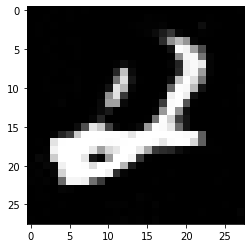

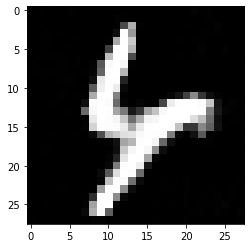

26th iteration gen_loss: 0.29107797145843506 dis_loss: 0.42710989713668823
26th iteration gen_loss: 0.2880898714065552 dis_loss: 0.46820634603500366


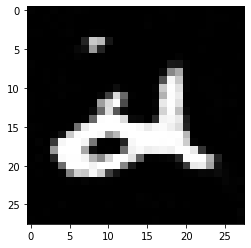

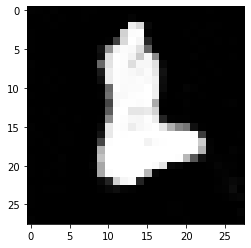

27th iteration gen_loss: 0.2733093500137329 dis_loss: 0.4534018039703369
27th iteration gen_loss: 0.25972557067871094 dis_loss: 0.46863263845443726


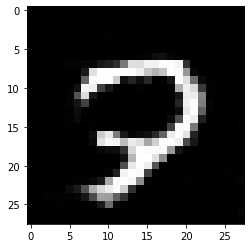

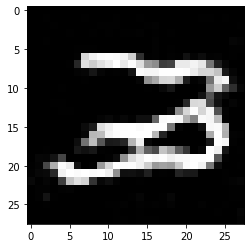

28th iteration gen_loss: 0.34763890504837036 dis_loss: 0.4333416819572449
28th iteration gen_loss: 0.26964071393013 dis_loss: 0.5009233951568604


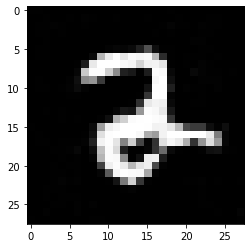

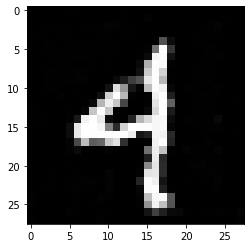

29th iteration gen_loss: 0.23985224962234497 dis_loss: 0.45626914501190186
29th iteration gen_loss: 0.2458600103855133 dis_loss: 0.452782541513443


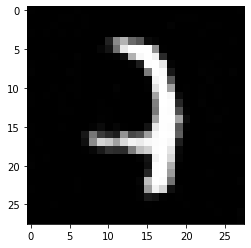

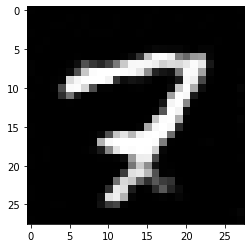

30th iteration gen_loss: 0.3138444125652313 dis_loss: 0.5094813108444214
30th iteration gen_loss: 0.38151541352272034 dis_loss: 0.4637189507484436


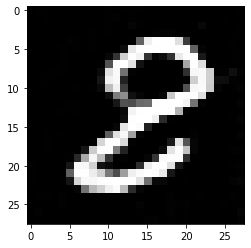

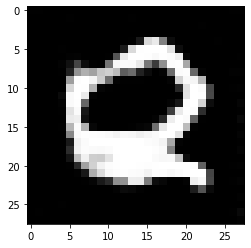

31th iteration gen_loss: 0.3576104938983917 dis_loss: 0.3880712687969208
31th iteration gen_loss: 0.2808263301849365 dis_loss: 0.4391082227230072


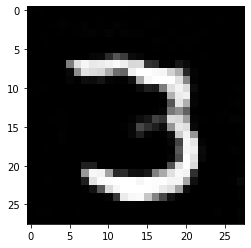

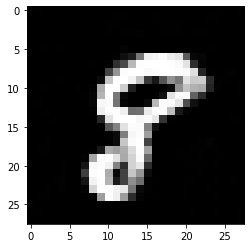

32th iteration gen_loss: 0.32144346833229065 dis_loss: 0.47956520318984985
32th iteration gen_loss: 0.25746864080429077 dis_loss: 0.5011690258979797


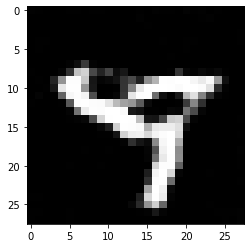

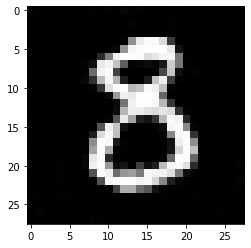

33th iteration gen_loss: 0.30621016025543213 dis_loss: 0.4870007634162903
33th iteration gen_loss: 0.2746082544326782 dis_loss: 0.47039198875427246


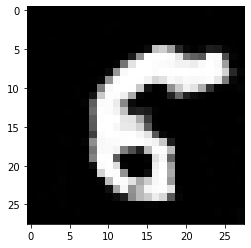

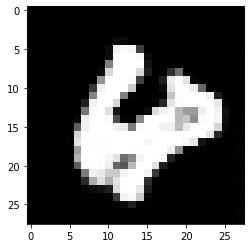

34th iteration gen_loss: 0.31624940037727356 dis_loss: 0.46841108798980713
34th iteration gen_loss: 0.29154711961746216 dis_loss: 0.5105023384094238


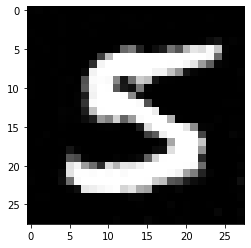

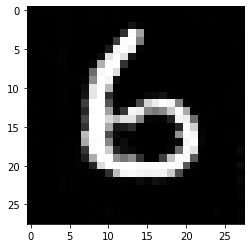

35th iteration gen_loss: 0.38090190291404724 dis_loss: 0.3343960642814636
35th iteration gen_loss: 0.2805516719818115 dis_loss: 0.48486679792404175


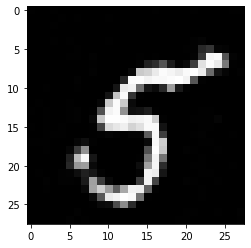

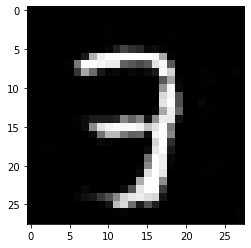

36th iteration gen_loss: 0.3432159125804901 dis_loss: 0.5013446807861328
36th iteration gen_loss: 0.27007514238357544 dis_loss: 0.48206397891044617


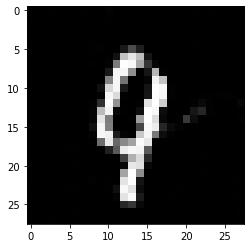

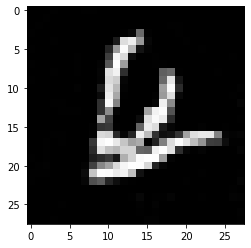

37th iteration gen_loss: 0.3056991696357727 dis_loss: 0.47745686769485474
37th iteration gen_loss: 0.33365219831466675 dis_loss: 0.4630863666534424


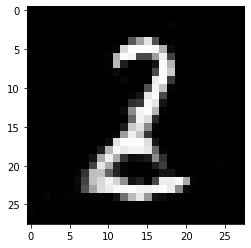

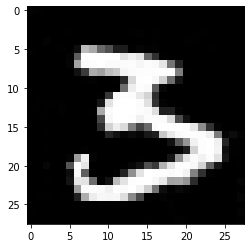

38th iteration gen_loss: 0.2726116478443146 dis_loss: 0.48435163497924805
38th iteration gen_loss: 0.3695651888847351 dis_loss: 0.448137104511261


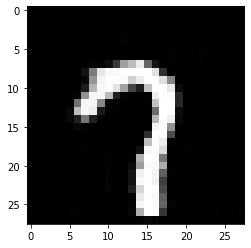

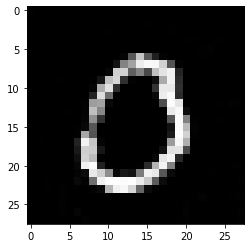

39th iteration gen_loss: 0.2810986340045929 dis_loss: 0.48308902978897095
39th iteration gen_loss: 0.28538063168525696 dis_loss: 0.4729315936565399


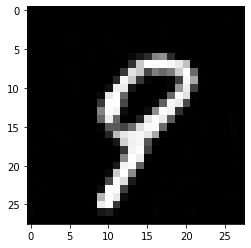

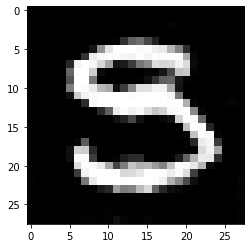

40th iteration gen_loss: 0.23957589268684387 dis_loss: 0.4601738750934601
40th iteration gen_loss: 0.28364622592926025 dis_loss: 0.5120983719825745


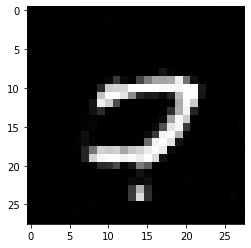

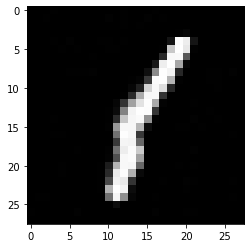

41th iteration gen_loss: 0.32087281346321106 dis_loss: 0.4882911443710327
41th iteration gen_loss: 0.27249860763549805 dis_loss: 0.47406718134880066


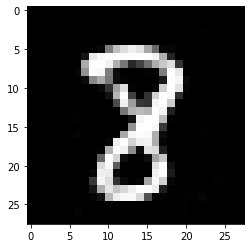

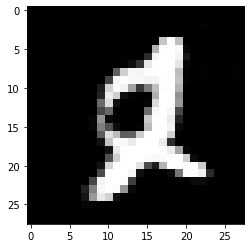

42th iteration gen_loss: 0.276415079832077 dis_loss: 0.5050023198127747
42th iteration gen_loss: 0.29458874464035034 dis_loss: 0.48784369230270386


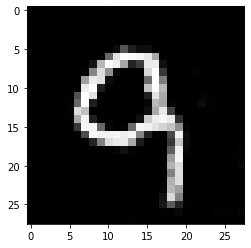

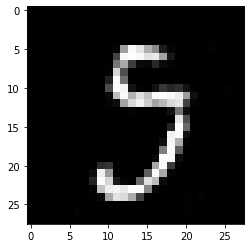

43th iteration gen_loss: 0.2689462900161743 dis_loss: 0.4904499650001526
43th iteration gen_loss: 0.2858487665653229 dis_loss: 0.4815506935119629


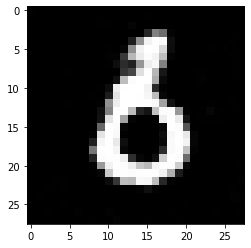

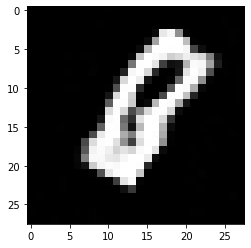

44th iteration gen_loss: 0.268324077129364 dis_loss: 0.4236948490142822
44th iteration gen_loss: 0.24560397863388062 dis_loss: 0.4607863426208496


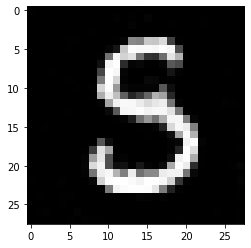

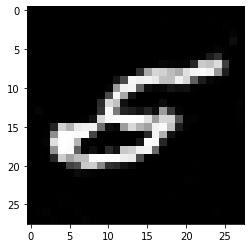

45th iteration gen_loss: 0.25794893503189087 dis_loss: 0.4602876901626587
45th iteration gen_loss: 0.28737756609916687 dis_loss: 0.4896339178085327


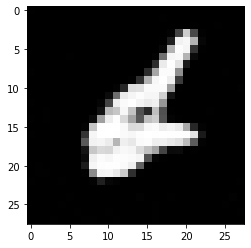

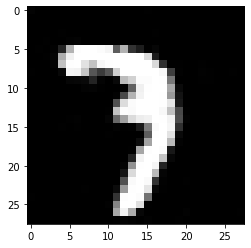

46th iteration gen_loss: 0.2944827377796173 dis_loss: 0.49015724658966064
46th iteration gen_loss: 0.29708385467529297 dis_loss: 0.504912257194519


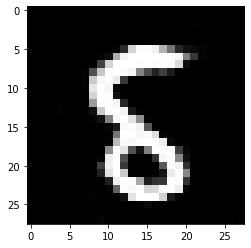

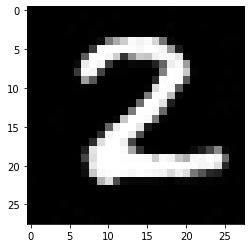

47th iteration gen_loss: 0.26125940680503845 dis_loss: 0.48567336797714233
47th iteration gen_loss: 0.24317453801631927 dis_loss: 0.493411123752594


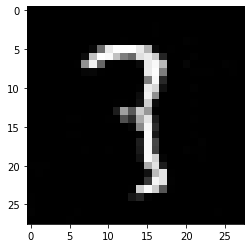

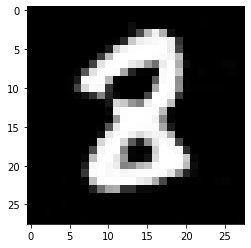

48th iteration gen_loss: 0.31113114953041077 dis_loss: 0.5030075311660767
48th iteration gen_loss: 0.24233756959438324 dis_loss: 0.46843934059143066


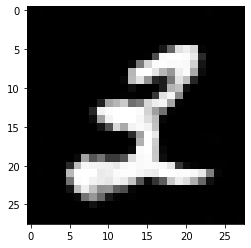

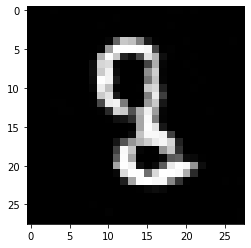

49th iteration gen_loss: 0.33825576305389404 dis_loss: 0.45926475524902344
49th iteration gen_loss: 0.32695063948631287 dis_loss: 0.4677770733833313


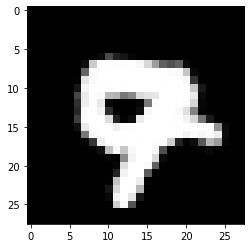

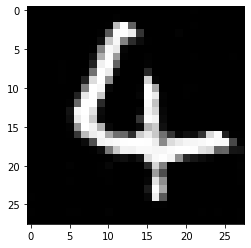

In [10]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = Variable(image).cuda()
        
        image = image[label != anomaly_digit] # оставляем для обучения только нормальные объекты
        label = label[label != anomaly_digit] # оставляем для обучения только нормальные объекты
        
        batch_size = image.shape[0]
        
        ones_label = Variable(torch.ones(batch_size,1)).cuda()
        zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

        
        # generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        dis_real,_ = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 50 == 0:
            #print(gen_loss,dis_loss)
            torch.save(generator.state_dict(),'./saved_model/generator.pkl')
            torch.save(discriminator.state_dict(),'./saved_model/discriminator.pkl')


            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)
            
    image_check(gen_fake.cpu())

## AnoGAN. Этап 2. Подсчёт расстояния до нормальных объектов и подбор 

In [11]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x,G_z,Lambda=0.1):
    _,x_feature = discriminator(x)
    _,G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z), dim=[1,2,3])
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature), 1)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

start_idx = 64
train_size = 500
test_size = 500


train_data_mnist = mnist_train.__dict__['data'][start_idx:start_idx+train_size]
train_label_mnist = mnist_train.__dict__['targets'][start_idx:start_idx+train_size] == anomaly_digit
train_data_mnist = train_data_mnist.view(train_size,1,28,28).type_as(torch.FloatTensor())
train_data_mnist.size()

test_data_mnist = mnist_test.__dict__['data'][start_idx:start_idx+test_size]
test_label_mnist = mnist_test.__dict__['targets'][start_idx:start_idx+test_size] == anomaly_digit
test_data_mnist = test_data_mnist.view(test_size,1,28,28).type_as(torch.FloatTensor())
test_data_mnist.size()

data_all = torch.cat([train_data_mnist, test_data_mnist])
label_all = torch.cat([train_label_mnist, test_label_mnist])

In [13]:
generator = nn.DataParallel(Generator(),device_ids=[0])
discriminator = nn.DataParallel(Discriminator(),device_ids=[0])

#generator,discriminator

In [14]:
# !rm -rf saved_model/

In [15]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))

    print("\n--------model restored--------\n")

except:
    print("\n--------model not restored--------\n")
    pass




--------model restored--------



In [16]:
z = Variable(init.normal(torch.zeros(train_size+test_size,100),mean=0,std=0.1),requires_grad=True) # для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
z_optimizer = torch.optim.Adam([z],lr=1e-4)

gen_fake = generator(z.cuda())
loss = Anomaly_score(Variable(data_all).cuda(),gen_fake) # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
print(loss.shape)
print(loss.mean())

/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


torch.Size([1000])
tensor(23034.0312, device='cuda:0', grad_fn=<MeanBackward0>)


In [17]:
for i in range(5000):
    gen_fake = generator(z.cuda())
    loss = Anomaly_score(Variable(data_all).cuda(),gen_fake,Lambda=0.01)
    loss.mean().backward() # минимизируем расстояние до нормального соседа
    z_optimizer.step() # обновляем ближайшего нормального соседа (z) для каждого объекта 
    
    if i%100==0:
        print(loss.mean().cpu().data)
        '''
        target = test_data_mnist[1,0,:,:].numpy()
        plt.imshow(target,cmap="gray")
        plt.show()
        
        img=gen_fake.cpu().data[1,0,:,:].numpy()
        plt.imshow(img,cmap='gray')
        plt.show()
        '''

tensor(25191.2988)
tensor(25168.0938)
tensor(25153.8398)
tensor(25144.1406)
tensor(25137.1543)
tensor(25131.9258)
tensor(25127.5293)
tensor(25123.7090)
tensor(25120.9766)
tensor(25118.3574)
tensor(25116.2773)
tensor(25114.3457)
tensor(25112.5098)
tensor(25110.8496)
tensor(25109.3535)
tensor(25108.0098)
tensor(25106.7930)
tensor(25105.5020)
tensor(25104.3691)
tensor(25103.2910)
tensor(25102.3789)
tensor(25101.4375)
tensor(25100.4941)
tensor(25099.5469)
tensor(25098.7402)
tensor(25097.9473)
tensor(25097.2207)
tensor(25096.5195)
tensor(25095.8457)
tensor(25095.2363)
tensor(25094.6621)
tensor(25094.0117)
tensor(25093.4199)
tensor(25092.8789)
tensor(25092.3691)
tensor(25091.8223)
tensor(25091.3418)
tensor(25090.9141)
tensor(25090.4414)
tensor(25089.9629)
tensor(25089.5059)
tensor(25089.0684)
tensor(25088.6406)
tensor(25088.2617)
tensor(25087.9004)
tensor(25087.5000)
tensor(25087.0820)
tensor(25086.7090)
tensor(25086.3574)
tensor(25086.0137)


## Посмотрим на ближайших соседей

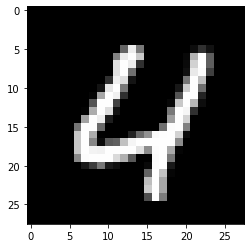

real data


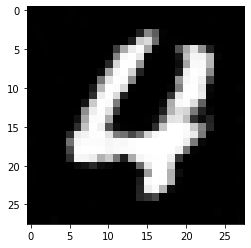

nearest neighbour

------------------------------------



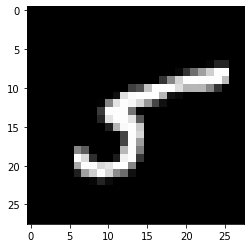

real data


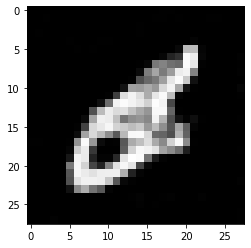

nearest neighbour

------------------------------------



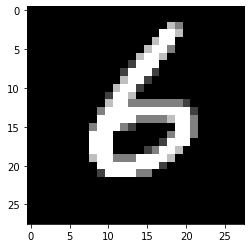

real data


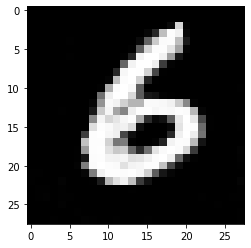

nearest neighbour

------------------------------------



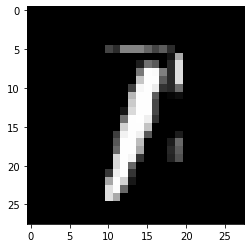

real data


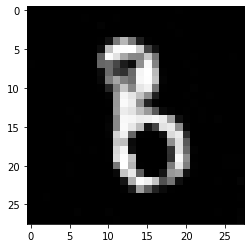

nearest neighbour

------------------------------------



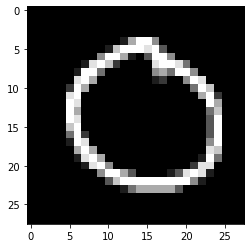

real data


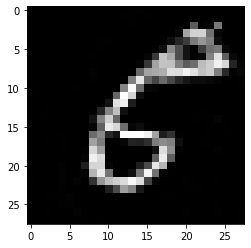

nearest neighbour

------------------------------------



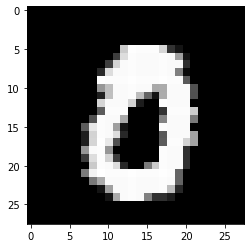

real data


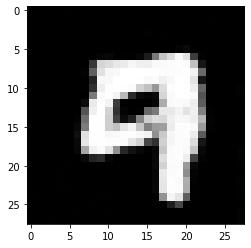

nearest neighbour

------------------------------------



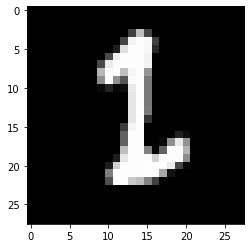

real data


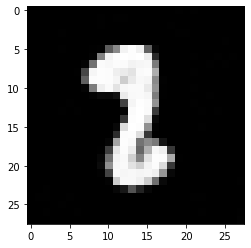

nearest neighbour

------------------------------------



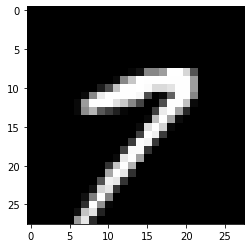

real data


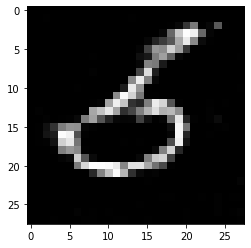

nearest neighbour

------------------------------------



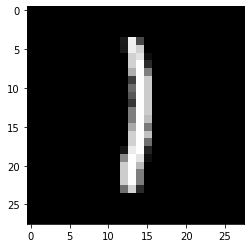

real data


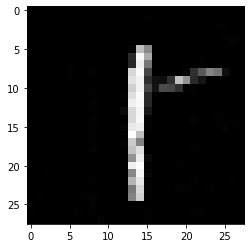

nearest neighbour

------------------------------------



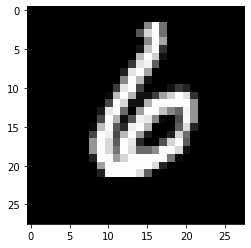

real data


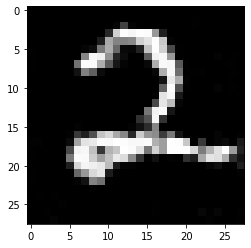

nearest neighbour

------------------------------------



In [18]:
for idx in range(10):
    target = data_all[idx,0,:,:].numpy()
    plt.imshow(target,cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:].numpy()
    plt.imshow(img,cmap='gray')
    plt.show()
    print("nearest neighbour")
    print("\n------------------------------------\n")

## Построим распределение расстояний для объектов

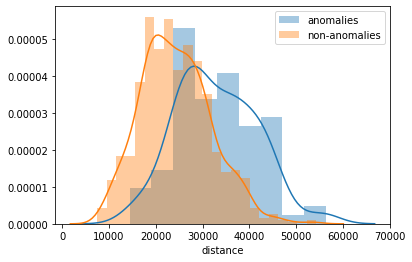

In [19]:
%matplotlib inline
import seaborn as sns
sns.distplot(loss[label_all].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~label_all].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()